## Importing Packages, Installing Census Data, and Defining Functions

In [ ]:
!pip install -q censusdata

In [1]:
import os
import shutil
import zipfile
import rasterio
import requests
import censusdata

import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

from pathlib import Path
from shapely.geometry import shape
from rasterio.features import shapes

In [2]:
def get_census_data(tables, state, county, year=2019):
    '''Download census data for a given state and county fips code.'''

    data = censusdata.download('acs5', year, censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]), list(tables.keys()))

    data.rename(columns=tables, inplace=True)

    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    
    return data

In [3]:
def get_census_tract_geom(state_fips, county_fips):
    '''Download census tract geometries for a given state and county fips code, storing in /tmp and cleaning up after.'''

    temp_dir = "/tmp/census_tracts"
    zip_path = os.path.join(temp_dir, f'tl_2019_{state_fips}_tract.zip')

    os.makedirs(temp_dir, exist_ok=True)

    url = f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip'
    response = requests.get(url, stream=True)
   
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")
        
    with open(zip_path, "wb") as file:
        file.write(response.content)

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    for file in os.listdir(temp_dir):
        if file.endswith(".shp"):
            shapefile_path = os.path.join(temp_dir, file)
            break

    tracts = gpd.read_file(shapefile_path)

    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts.rename(columns={'TRACTCE': 'Tract'}).set_index('Tract')

    shutil.rmtree(temp_dir)

    return tracts[['geometry']]

---
# Spokane 

In [38]:
## PARKS
parks_fn = "./Data/protected_places.geojson"
parks_gdf = gpd.read_file(parks_fn)

## STATE DATA
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)

In [5]:
idx = states_gdf["NAME"].isin(["Washington"])
wa_state_gdf = states_gdf[idx]

In [6]:
tables = {
'B19013_001E': 'MedianIncome',
'B01003_001E': 'TotalPopulation',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',
'B25035_001E': 'MedianYearStructureBuilt',
'B25001_001E': 'TotalHousingUnits',
'B25004_001E': 'TotalVacantHousingUnits',
'B25003_002E': 'OccupiedHousingUnitsOwnerOccupied',
'B25003_003E': 'OccupiedHousingUnitsRenterOccupied'
}

In [20]:
state_fips = '53'  # FIPS code for Washington
county_fips = '063'  # FIPS code for Spokane County

census_df = get_census_data(tables, state_fips, county_fips)
tract_geom_gdf = get_census_tract_geom(state_fips, county_fips).to_crs(parks_gdf.crs)
spokane_gdf = gpd.GeoDataFrame(census_df.join(tract_geom_gdf)).to_crs(parks_gdf.crs)

In [21]:
spokane_gdf = spokane_gdf.overlay(parks_gdf, how='difference')
tract_geom_gdf = tract_geom_gdf.overlay(parks_gdf, how='difference')

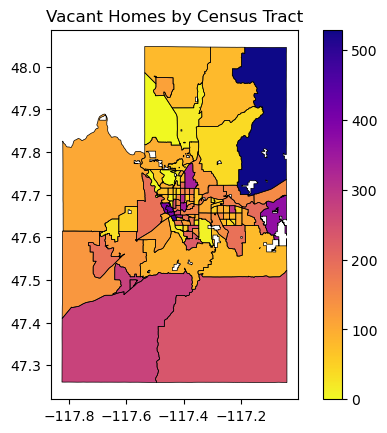

In [22]:
fig,ax = plt.subplots()

spokane_gdf.plot(ax=ax, column="TotalVacantHousingUnits", cmap="plasma_r", legend=True)
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none', linewidth=0.5)

plt.title("Vacant Homes by Census Tract")

plt.show()

--- 
## Slope 
- slope_Spokane is slope_spo
- census_Spokane_gdf is spokane_gdf

In [23]:
dem_data = f'{Path.home()}/gda_demo_data/dem_data'
dem_fn = os.path.join(dem_data, "WA_COP90.tif")

proj_fn = os.path.splitext(dem_fn)[0]+'_utm_gdalwarp.tif'
slope_fn = os.path.splitext(proj_fn)[0]+'_slope.tif'

In [24]:
!gdaldem slope $proj_fn $slope_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [25]:
slope_ras = rxr.open_rasterio(slope_fn, masked=True).squeeze()
slope_ras = slope_ras.rio.reproject(spokane_gdf.crs)

census_geom = spokane_gdf.geometry.union_all() 
slope_spo = slope_ras.rio.clip([census_geom], spokane_gdf.crs)

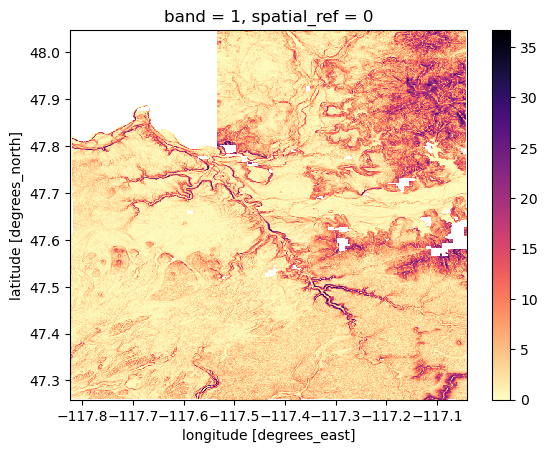

In [26]:
slope_spo.plot(cmap="magma_r")

--- 
## Flood Plains

In [39]:
floodplains_fn = './Data/FEMA_Flood_Zone.geojson'
floodplains_gdf = gpd.read_file(floodplains_fn).to_crs(4326)

<Axes: >

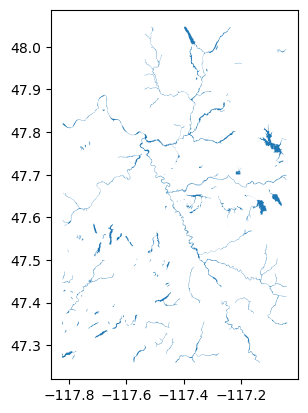

In [40]:
floodplains_gdf.plot()

---
## Land Cover

In [ ]:
dst_crs = 'EPSG:4326'

In [ ]:
land_use_fn = "./Data/land_use.tif"

In [ ]:
proj_land_fn = os.path.splitext(land_use_fn)[0]+'_utm_gdalwarp.tif'

In [ ]:
!gdalwarp -srcnodata 0 -t_srs $dst_crs $land_use_fn $proj_land_fn

In [ ]:
land_use_da = rxr.open_rasterio(proj_land_fn).squeeze()

In [ ]:
X, Y = np.meshgrid(land_use_da.x.values, land_use_da.y.values)
plt.pcolormesh(X, Y, land_use_da.values, cmap='Greens')

---
## Radiation

In [ ]:
radiation_fn = "./Data/radiation.tif"

In [ ]:
proj_ra_fn = os.path.splitext(radiation_fn)[0]+'_utm_gdalwarp.tif'

In [ ]:
!gdalwarp -srcnodata 0 -t_srs $dst_crs $radiation_fn $proj_ra_fn

In [ ]:
radiation_da = rxr.open_rasterio(proj_ra_fn).squeeze()

---